In [1]:
import math
import random
import time
from jupyterthemes import jtplot
jtplot.style()

import gym
gym.logger.set_level(40)
import numpy as np


import nnabla as nn
import nnabla.logger as logger
import nnabla.functions as F
import nnabla.parametric_functions as PF
import nnabla.solver as S
from nnabla.contrib.context import extension_context
from nnabla.monitor import Monitor, MonitorSeries, MonitorTimeElapsed

2018-08-13 18:41:21,033 [nnabla][INFO]: Initializing CPU extension...


In [2]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
epsilon_start = 1.0
epsilon_final = 0.001 #0.01
epsilon_decay = 500 #500
epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)
#plt.plot([epsilon_by_frame(i) for i in range(10000)])

In [4]:
from collections import deque
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [5]:
env = gym.make("CartPole-v0")
state_num = env.observation_space.shape[0]
action_num = env.action_space.n
hidden_size = 32 #128
max_frames = 20000
state_size = 1
batch_size = 32
replay_buffer_size = 1000
gamma = 0.99
learning_rate = 1e-3

In [6]:
def DQN(state):
    with nn.parameter_scope("DQN"):
        with nn.parameter_scope("affine1"):
            h = F.relu(PF.affine(state, hidden_size))
        with nn.parameter_scope("affine2"):
            h = F.relu(PF.affine(h, hidden_size))
        with nn.parameter_scope("affine3"):
            Q = PF.affine(h, action_num)
    return Q

def act(state, epsilon):
    if random.random() > epsilon:
        State = nn.Variable([1, state_num])
        State.d = state
        Q_act = DQN(State)
        Q_act.forward()
        action  = np.argmax(Q_act.d)
    else:
        action = random.randrange(action_num)
    return action

In [7]:
replay_buffer = ReplayBuffer(replay_buffer_size)

#変数定義
State = nn.Variable([32, 4]) #あとで次元数変数で定義
Action = nn.Variable([32, 1])
Q = DQN(State)
Q_value = F.sum(F.one_hot(Action, (2,)) * Q, axis=1, keepdims=True)#QからActionのやつを抜き出す
next_Q_value = F.max(Q, axis=1, keepdims=True) #Qから最大のもので一列作る
expected_Q_value = nn.Variable([32, 1])

#損失関数定義
loss = F.squared_error(Q_value, expected_Q_value)

#solver定義
solver = S.Adam(learning_rate)
with nn.parameter_scope("DQN"):
    solver.set_parameters(nn.get_parameters())
solver.zero_grad()

losses = []
overall_rewards = []
episode_reward = 0

In [8]:
def compute_td_loss(batch_size):
    global State, Q, t, loss
    #リプレイサンプル
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    #変数代入
    State.d = state
    Next_State = nn.Variable.from_numpy_array(next_state)
    Reward = np.array(reward).reshape([batch_size,1])
    Done =np.array(done).reshape([batch_size,1])
    
    #行動の次元数が1のとき
    action = np.array(action)
    action = action.reshape([batch_size,1])
    Action.d = action
#    Action.d = np.ones([32,1])
    
    Q.forward()
    Q_value.forward()
    
    #変数代入
    next_Q = DQN(Next_State)
    next_Q.forward()
    next_Q_value = np.max(next_Q.d, axis=1, keepdims=True)
    expected_Q_value.d = Reward + gamma * next_Q_value * (1 - Done)
    
    loss.forward()
    solver.zero_grad()
    loss.backward()
    solver.update()
    
    return loss

In [9]:
def plot(frame, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

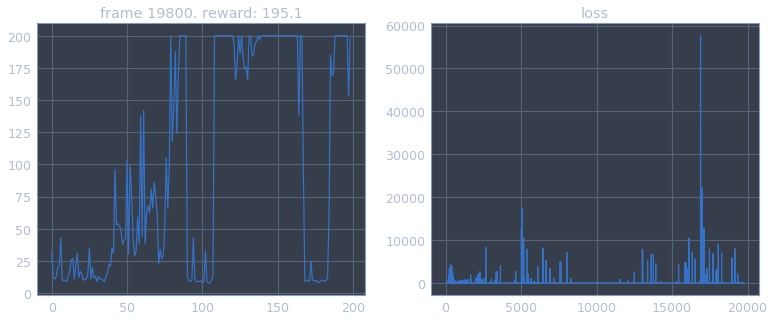

In [10]:
state = env.reset()
#nn.clear_parameters()
for frame in range(1, max_frames):
    epsilon = epsilon_by_frame(frame)
    action = act(state, epsilon)
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    state = next_state
    episode_reward += reward   
    if done:
        state = env.reset()
        overall_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(np.average(loss.d[0]))
    if frame % 200 == 0:
        plot(frame, overall_rewards, losses)
#TODO ターゲットネットワーク